In [1]:
from sklearn import svm,metrics,model_selection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import feature

In [2]:
data = pd.read_csv("train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
images = data.ix[:, 1:].as_matrix().reshape((-1,28,28))
labels = data.ix[:, 0].as_matrix()

In [4]:
def show_img(image):
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

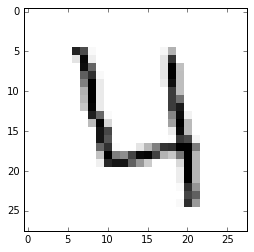

In [5]:
show_img(images[3])

In [6]:
class LocalBinaryPatterns:
    def __init__(self, numPoints=8, radius=1):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
 
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
 
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
 
        # return the histogram of Local Binary Patterns
        return hist

In [7]:
feature_extractor = LocalBinaryPatterns(numPoints=16, radius=2)
image_num = np.shape(images)[0]

image_features = [feature_extractor.describe(image) for image in images]

In [8]:
featured_data = pd.DataFrame(np.concatenate((np.transpose([labels]), image_features), axis=1))
featured_data.to_csv("featured_data.csv")
featured_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.0,0.019133,0.015306,0.008929,0.002551,0.002551,0.002551,0.006378,0.003827,0.026786,0.008929,0.005102,0.000000,0.000000,0.000000,0.0,0.0,0.876276,0.021684
1,0.0,0.000000,0.003827,0.000000,0.001276,0.000000,0.002551,0.014031,0.057398,0.052296,0.029337,0.019133,0.005102,0.000000,0.000000,0.0,0.0,0.687500,0.127551
2,1.0,0.002551,0.000000,0.015306,0.002551,0.000000,0.002551,0.005102,0.001276,0.016582,0.019133,0.002551,0.000000,0.000000,0.000000,0.0,0.0,0.899235,0.033163
3,4.0,0.020408,0.026786,0.001276,0.002551,0.002551,0.001276,0.001276,0.005102,0.011480,0.007653,0.003827,0.002551,0.001276,0.001276,0.0,0.0,0.855867,0.054847
4,0.0,0.001276,0.007653,0.000000,0.000000,0.000000,0.001276,0.012755,0.035714,0.065051,0.052296,0.021684,0.007653,0.000000,0.000000,0.0,0.0,0.668367,0.126276


In [264]:
train_data = featured_data.sample(2000)
train_features = train_data.ix[:, 1:].values
train_labels = train_data.ix[:, 0].values.astype(int)
classifier = svm.SVC(decision_function_shape="ovr", gamma=1)
classifier.fit(train_features, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [273]:
test_data = featured_data.sample(2000)
test_features = test_data.ix[:, 1:].values
test_labels = test_data.ix[:, 0].values
predicted_labels = classifier.predict(test_features)

In [274]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(test_labels, predicted_labels)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.59      0.77      0.67       209
        1.0       0.86      0.94      0.89       232
        2.0       0.21      0.12      0.16       186
        3.0       0.33      0.47      0.38       197
        4.0       0.38      0.26      0.31       192
        5.0       0.67      0.01      0.02       189
        6.0       0.35      0.13      0.19       195
        7.0       0.36      0.66      0.46       210
        8.0       0.55      0.63      0.59       190
        9.0       0.32      0.43      0.37       200

avg / total       0.47      0.46      0.42      2000




In [ ]:
train_data = featured_data.sample(5000)
train_features = train_data.ix[:, 1:].values
train_labels = train_data.ix[:, 0].values.astype(int)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = model_selection.GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(train_features, train_labels)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))